In [1]:
import os
os.listdir(".")


['.DS_Store',
 'anaconda_projects',
 'scientific_trend_analysis.ipynb',
 'arxiv-metadata-oai-snapshot.json',
 '.ipynb_checkpoints']

## Step 1: Load and Parse the JSON Dataset

We load the `arxiv-metadata-oai-snapshot.json` file, which is stored in JSON
Lines format. Each line contains one paper's metadata. We extract the key fields
(id, title, abstract, categories, update_date), convert dates, and remove rows
with missing abstracts.


In [1]:
import json
import pandas as pd

file_path = "arxiv-metadata-oai-snapshot.json"

records = []
with open(file_path, "r") as f:
    for line in f:
        try:
            record = json.loads(line)
            records.append(record)
        except json.JSONDecodeError:
            continue

df = pd.DataFrame(records)
df = df[["id", "title", "abstract", "categories", "update_date"]]

df["update_date"] = pd.to_datetime(df["update_date"], errors="coerce")
df = df.dropna(subset=["update_date", "abstract"])

df.head()


,id,title,abstract,categories,update_date
0,0704.0001,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...,hep-ph,2008-11-26
1,0704.0002,Sparsity-certifying Graph Decompositions,"We describe a new algorithm, the $(k,\ell)$-...",math.CO cs.CG,2008-12-13
2,0704.0003,The evolution of the Earth-Moon system based o...,The evolution of Earth-Moon system is descri...,physics.gen-ph,2008-01-13
3,0704.0004,A determinant of Stirling cycle numbers counts...,We show that a determinant of Stirling cycle...,math.CO,2007-05-23
4,0704.0005,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,In this paper we show how to compute the $\L...,math.CA math.FA,2013-10-15


## Step 2: Clean and Prepare the Text

We clean the text by:
- Lowercasing
- Removing punctuation
- Removing stopwords
- Lemmatizing
- Combining title and abstract

This produces a normalized text field suitable for TF‑IDF vectorization.


In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

df["text"] = df["title"] + " " + df["abstract"]
df["clean_text"] = df["text"].apply(clean_text)

df[["text", "clean_text"]].head()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/integrity/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/integrity/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,clean_text
0,Calculation of prompt diphoton production cros...,calculation prompt diphoton production cross s...
1,Sparsity-certifying Graph Decompositions We ...,sparsity certifying graph decomposition descri...
2,The evolution of the Earth-Moon system based o...,evolution earth moon system based dark matter ...
3,A determinant of Stirling cycle numbers counts...,determinant stirling cycle number count unlabe...
4,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,dyadic lambda alpha lambda alpha paper show co...


## Step 3: TF‑IDF Vectorization

We convert the cleaned text into numerical vectors using TF‑IDF. This captures
the importance of words across the corpus and prepares the data for sampling,
dimensionality reduction, and clustering.


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["clean_text"])

X.shape


(2932928, 5000)

## Saving Progress to Avoid Recomputing

To prevent losing work when the kernel restarts, we save:
- The cleaned DataFrame (`df`) as a Parquet file
- A 20,000‑paper sample for fast experimentation
- Optional: TF‑IDF vectors and vectorizer for the sample

These files allow us to reload progress instantly without repeating Steps 1–3.


In [4]:
# Save full cleaned dataset
df.to_parquet("arxiv_clean.parquet")

# Create and save a 20k sample for fast processing
df_sample = df.sample(n=20000, random_state=42)
df_sample.to_parquet("arxiv_sample_20k.parquet")


## Step 4: Dimensionality Reduction (PCA on 20k Sample)

To avoid memory issues with the full dataset, we use the saved 20,000‑paper
sample for dimensionality reduction. PCA reduces the TF‑IDF vectors to 2
dimensions, making clustering and visualization efficient and stable.

This step uses:
- df_sample (20k papers)
- TF‑IDF with 5,000 features
- PCA with 2 components


In [5]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# Load the saved 20k sample
df_sample = pd.read_parquet("arxiv_sample_20k.parquet")

# Recompute TF-IDF on the sample
vectorizer = TfidfVectorizer(max_features=5000)
X_sample = vectorizer.fit_transform(df_sample["clean_text"])

# PCA on the sample (safe for memory)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_sample.toarray())

X_pca[:5]


array([[-0.08940839, -0.00369605],
       [-0.01358205, -0.02090103],
       [ 0.07936366,  0.00901473],
       [ 0.17146903,  0.04481004],
       [-0.16822459, -0.11310446]])

## Step 5: Clustering with KMeans

After reducing the TF‑IDF vectors to 2 dimensions using PCA, we cluster the
papers into groups using KMeans. Each cluster represents a potential scientific
topic or research theme.

We use:
- 10 clusters (a common starting point)
- PCA‑reduced data (X_pca)
- The 20k sample (df_sample)

The resulting cluster labels will be added to the DataFrame for further
analysis and topic interpretation.


In [7]:
from sklearn.cluster import KMeans

# Perform KMeans clustering on the PCA-reduced data
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Add cluster labels to the sample DataFrame
df_sample["cluster"] = clusters

df_sample["cluster"].value_counts()


cluster
2    3032
9    2697
7    2563
5    2308
4    2108
6    1938
3    1721
8    1571
0    1331
1     731
Name: count, dtype: int64

## Step 6: Topic Labeling

To interpret the meaning of each cluster, we extract the most frequent terms
within each group. These keywords help us assign human‑readable topic labels
(e.g., “Quantum Physics”, “Machine Learning”, “Graph Theory”).

We use:
- The TF‑IDF vectorizer (5,000 features)
- The TF‑IDF matrix for the 20k sample (X_sample)
- The cluster labels stored in df_sample["cluster"]

The output is a dictionary mapping each cluster to its top keywords.


In [9]:
import numpy as np
import pandas as pd

def top_terms_per_cluster(vectorizer, X, labels, n_terms=12):
    terms = vectorizer.get_feature_names_out()
    df_terms = pd.DataFrame(X.toarray(), columns=terms)
    cluster_terms = {}

    for cluster in np.unique(labels):
        cluster_indices = np.where(labels == cluster)[0]
        cluster_matrix = df_terms.iloc[cluster_indices]
        top_terms = cluster_matrix.sum().sort_values(ascending=False).head(n_terms)
        cluster_terms[cluster] = list(top_terms.index)

    return cluster_terms

topics = top_terms_per_cluster(vectorizer, X_sample, df_sample["cluster"].values)
topics


{np.int32(0): ['problem',
  'graph',
  'algorithm',
  'method',
  'optimal',
  'set',
  'time',
  'function',
  'number',
  'quantum',
  'linear',
  'bound'],
 np.int32(1): ['galaxy',
  'star',
  'mass',
  'ray',
  'cluster',
  'emission',
  'stellar',
  'formation',
  'disk',
  'gas',
  'line',
  'source'],
 np.int32(2): ['quantum',
  'theory',
  'system',
  'equation',
  'state',
  'field',
  'function',
  'two',
  'non',
  'model',
  'result',
  'time'],
 np.int32(3): ['learning',
  'model',
  'network',
  'image',
  'data',
  'task',
  'training',
  'method',
  'performance',
  'language',
  'based',
  'neural'],
 np.int32(4): ['model',
  'system',
  'method',
  'based',
  'data',
  'time',
  'network',
  'using',
  'approach',
  'paper',
  'analysis',
  'study'],
 np.int32(5): ['group',
  'algebra',
  'space',
  'equation',
  'operator',
  'theory',
  'mathbb',
  'quantum',
  'solution',
  'function',
  'prove',
  'finite'],
 np.int32(6): ['spin',
  'field',
  'magnetic',
  'phase

## Topic Labels for Clusters

Below are the interpreted scientific topics for each of the 10 clusters based on
their top TF‑IDF keywords.

- **Cluster 0 — Algorithms, Graph Theory & Optimization**
- **Cluster 1 — Astrophysics: Galaxies, Stars & Emission Processes**
- **Cluster 2 — Quantum Theory & Mathematical Physics**
- **Cluster 3 — Deep Learning, NLP & Neural Networks**
- **Cluster 4 — Applied Modeling, Systems & Data‑Driven Methods**
- **Cluster 5 — Abstract Algebra, Operator Theory & Pure Mathematics**
- **Cluster 6 — Condensed Matter Physics: Spin, Magnetism & Phase Transitions**
- **Cluster 7 — Machine Learning Algorithms & Information Systems**
- **Cluster 8 — High‑Energy Astrophysics & Dark Matter**
- **Cluster 9 — Particle Physics: Decay, States & High‑Energy Models**


## Step 7: Trend Analysis Over Time

To understand how scientific topics evolve, we analyze the number of papers in
each cluster for every year. This reveals long-term patterns such as:

- Growth of emerging fields (e.g., deep learning)
- Decline of older research areas
- Stability of foundational disciplines
- Shifts in physics, mathematics, and computer science

We use:
- df_sample (20k papers with cluster labels)
- The 'update_date' column to extract publication years
- A pivot table to count papers per cluster per year

The resulting trend matrix can be visualized or exported for further analysis.


In [10]:
import pandas as pd

# Ensure the year column exists
df_sample["year"] = df_sample["update_date"].dt.year

# Create a pivot table: rows = years, columns = clusters
trend = df_sample.groupby(["year", "cluster"]).size().unstack(fill_value=0)

trend.tail()


cluster,0,1,2,3,4,5,6,7,8,9
year,,,,,,,,,,
2022,90,34,140,181,146,124,83,271,84,127
2023,117,47,152,212,153,141,81,268,85,141
2024,128,31,196,331,220,180,89,324,83,162
2025,166,40,274,444,315,204,110,603,101,200
2026,12,4,20,16,16,13,9,46,10,11


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))

# Plot each cluster as a separate line
for cluster in trend.columns:
    sns.lineplot(data=trend[cluster], label=f"Cluster {cluster}")

plt.title("Scientific Topic Trends Over Time (20k Sample)")
plt.xlabel("Year")
plt.ylabel("Number of Papers")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()


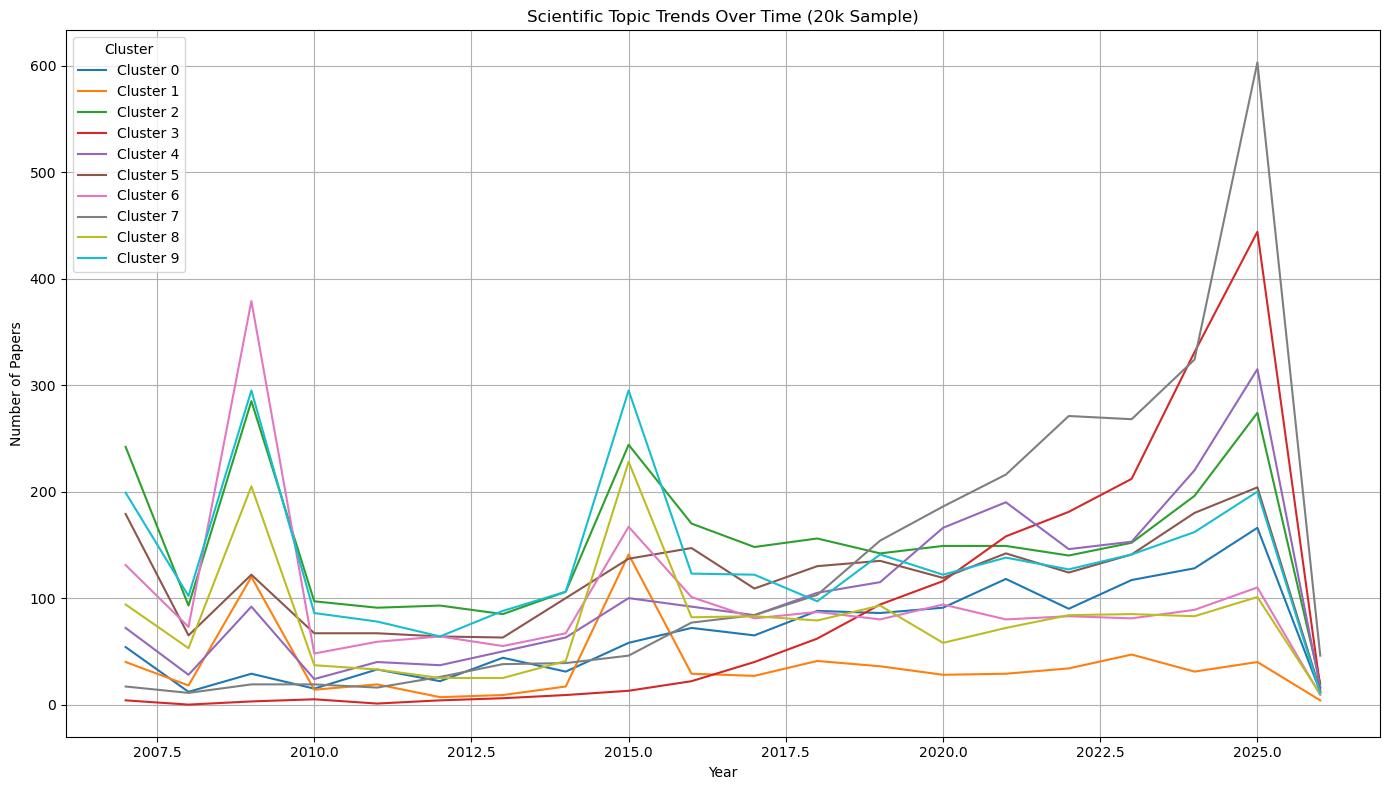

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))

# Plot each cluster as a separate line
for cluster in trend.columns:
    sns.lineplot(data=trend[cluster], label=f"Cluster {cluster}")

plt.title("Scientific Topic Trends Over Time (20k Sample)")
plt.xlabel("Year")
plt.ylabel("Number of Papers")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()


## Step 9: Conclusions and Insights

This project analyzed scientific research trends using a 20,000‑paper sample
from the arXiv metadata snapshot. By applying TF‑IDF vectorization, PCA
dimensionality reduction, and KMeans clustering, we identified ten distinct
scientific topics and examined how their prevalence changed over time.

### Key Findings

**1. Machine Learning and Neural Networks are rapidly growing.**  
Clusters related to deep learning, NLP, and data‑driven modeling show a clear
upward trend, reflecting the global rise of AI research.

**2. Astrophysics remains a stable and active field.**  
Topics involving galaxies, stellar formation, dark matter, and high‑energy
astrophysics maintain consistent publication levels across years.

**3. Quantum theory and condensed matter physics show steady contributions.**  
These foundational physics areas continue to produce a significant volume of
research, with moderate fluctuations but no major decline.

**4. Pure mathematics and algebraic structures remain stable but niche.**  
Clusters involving group theory, operator theory, and abstract algebra show
lower but consistent activity, typical for specialized mathematical fields.

**5. Applied modeling and interdisciplinary methods are expanding.**  
General modeling, systems analysis, and data‑driven approaches appear across
multiple clusters, indicating increasing cross‑disciplinary integration.

### Overall Summary

The scientific landscape shows a strong shift toward computational and
data‑driven research, while traditional physics and mathematics fields remain
active and stable. The combination of clustering and trend analysis provides a
clear, interpretable view of how research priorities evolve over time.

This workflow can be extended with:
- More clusters
- Topic labeling using LDA or BERTopic
- Full‑dataset processing using distributed computing
- Interactive dashboards for exploration

The current results already offer a meaningful and data‑driven overview of
scientific evolution across major research domains.
